# Binary Huffman code for encoding speech signals

**EE4740 Data Compression: Entropy and Sparsity Perspectives**

***Author: Yanqi Hong***

## 1. Import libraries


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import wave
import sys
import os
import struct
import math
import scipy.signal as signal
import scipy.io.wavfile as wav
import scipy.fftpack
from scipy.io.wavfile import write
import pandas as pd
from collections import Counter
from collections import namedtuple
from heapq import heapify, heappop, heappush
import networkx as nx
from EoN import hierarchy_pos
from IPython.display import Audio
import time


import random
# random.seed(123)


## 2. Data preprocessing


In [53]:

# Import data
main_folder_path = "E:\DATA\TUD\Master\TUD_Master_Y1\Q3\EE4740 Data Compression Entropy and Sparsity Perspectives\Mini Project\Audio Data\Audio Data"

# Create dictionaries to store the wav files
wav_files_F = {}
wav_files_M = {}

# Function to read the wav file
def read_wav_file(file_path):
    # Open the file
    file = wave.open(file_path, 'r')
    # Get the number of frames
    num_frames = file.getnframes()
    # Get the sample rate
    sample_rate = file.getframerate()
    # Get the frames
    frames = file.readframes(num_frames)
    # Close the file
    file.close()
    # Unpack the frames
    frames = struct.unpack("<" + str(num_frames) + "h", frames)
    # Convert the frames to an array
    frames = np.array(frames)
    return frames, sample_rate

# Iterate over the folders in the main folder path
for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)
    if os.path.isdir(folder_path):
        # Check if the folder name starts with "F" or "M"
        if folder_name.startswith("F"):
            wav_files_F[folder_name] = {}
        elif folder_name.startswith("M"):
            wav_files_M[folder_name] = {}
        
        # Iterate over the wav files in the folder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_name.endswith(".wav"):
                frames, sample_rate = read_wav_file(file_path)
                if folder_name.startswith("F"):
                    wav_files_F[folder_name][file_name] = {'frames': frames, 'sample_rate': sample_rate}
                elif folder_name.startswith("M"):
                    wav_files_M[folder_name][file_name] = {'frames': frames, 'sample_rate': sample_rate}




In [54]:
# Create a dictionary to store the data
                    
def show_file_property(wav_files_dic):
    data = {'Folder': [], 'Wav File': [], 'Sample Rate': [], 'Number of Frames': []}
    # Iterate over the folders in the wav files
    for folder_name in wav_files_dic:
        for file_name in wav_files_dic[folder_name]:
            data['Folder'].append(folder_name)
            data['Wav File'].append(file_name)
            data['Sample Rate'].append(wav_files_dic[folder_name][file_name]['sample_rate'])
            data['Number of Frames'].append(len(wav_files_dic[folder_name][file_name]['frames']))
    # Create a dataframe
    df = pd.DataFrame(data)
    display(df)

show_file_property(wav_files_F)
show_file_property(wav_files_M)

# create a list to saave all the audio data, first 8 value is female and the rest is male
audio_data = []
for folder_name in wav_files_F:
    for file_name in wav_files_F[folder_name]:
        audio_data.append(wav_files_F[folder_name][file_name]['frames'])

for folder_name in wav_files_M:
    for file_name in wav_files_M[folder_name]:
        audio_data.append(wav_files_M[folder_name][file_name]['frames'])



print(audio_data)





Folder    Wav File  Sample Rate  Number of Frames
0     F1     SA1.wav         8000             31744
1     F1  SI1573.wav         8000             39783
2     F2   SX304.wav         8000             22375
3     F2    SX34.wav         8000             18893
4     F3  SI2114.wav         8000             20480
5     F3   SX134.wav         8000             22477
6     F4  SI2204.wav         8000             30874
7     F4   SX224.wav         8000             12903

Folder    Wav File  Sample Rate  Number of Frames
0     M1     SA2.wav         8000             18535
1     M1  SI2293.wav         8000             28928
2     M2   SI602.wav         8000             31130
3     M2   SX374.wav         8000             18023
4     M3   SX199.wav         8000             31028
5     M3   SX289.wav         8000             25652
6     M4  SI1019.wav         8000             25754
7     M4   SX389.wav         8000             25703

[array([13, 13,  5, ..., 32, 28, 41]), array([  3,  12,   5, ...,   7,  -8, -11]), array([-18,  -6,   6, ...,  -4,   9,  -1]), array([-12, -28,  16, ...,  20,  -3, -12]), array([ 17, -29, -97, ...,   9,  -4,   3]), array([ 57, -33, -79, ..., -32,  -5,  39]), array([16, 28, 63, ..., 38, 79, 87]), array([21, 52, 60, ..., 59, 49, 56]), array([11, 14, -6, ..., 23, 44, 34]), array([16, 18, 18, ..., 10, 20,  4]), array([51, 15, 24, ..., -6,  8,  1]), array([-121,   12,    7, ...,   -7,    2,    4]), array([-28,  11,  13, ...,  29,  35,  12]), array([-6, 35, 57, ..., 39, 41, 28]), array([ 87, 113,  37, ...,  15, -14,  -7]), array([ 6,  6, 21, ..., 13,  8, 24])]


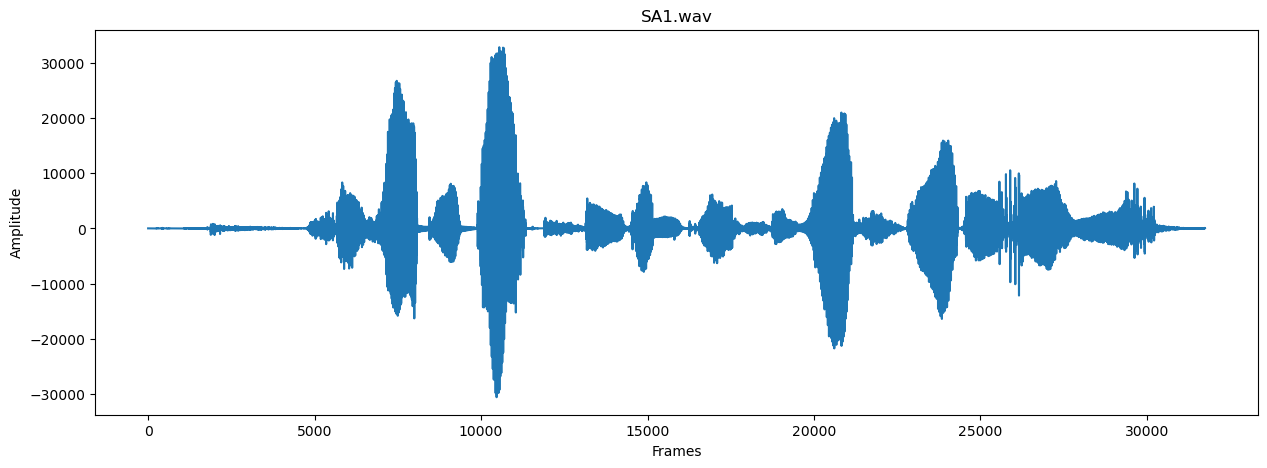

In [55]:
# Function to plot the wav file
def plot_wav_file(frames, title):
    # Create the time array
    frame = np.arange(0, len(frames))
    # Plot the wav file
    plt.plot(frame, frames)
    plt.title(title)
    plt.xlabel("Frames")
    plt.ylabel('Amplitude')
    #plt size
    plt.rcParams["figure.figsize"] = (15,5)
    plt.show()

plot_wav_file(wav_files_F['F1']['SA1.wav']['frames'], 'SA1.wav')

[13 13  5 ... 32 28 41]


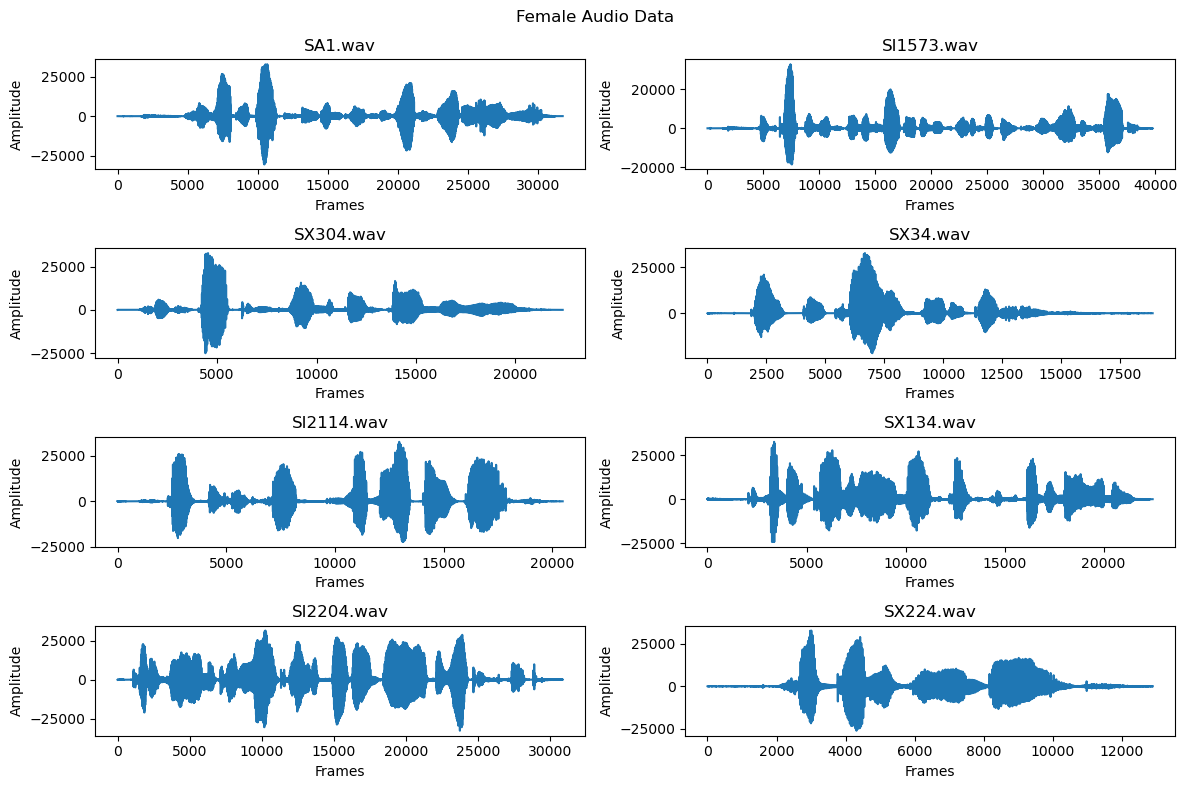

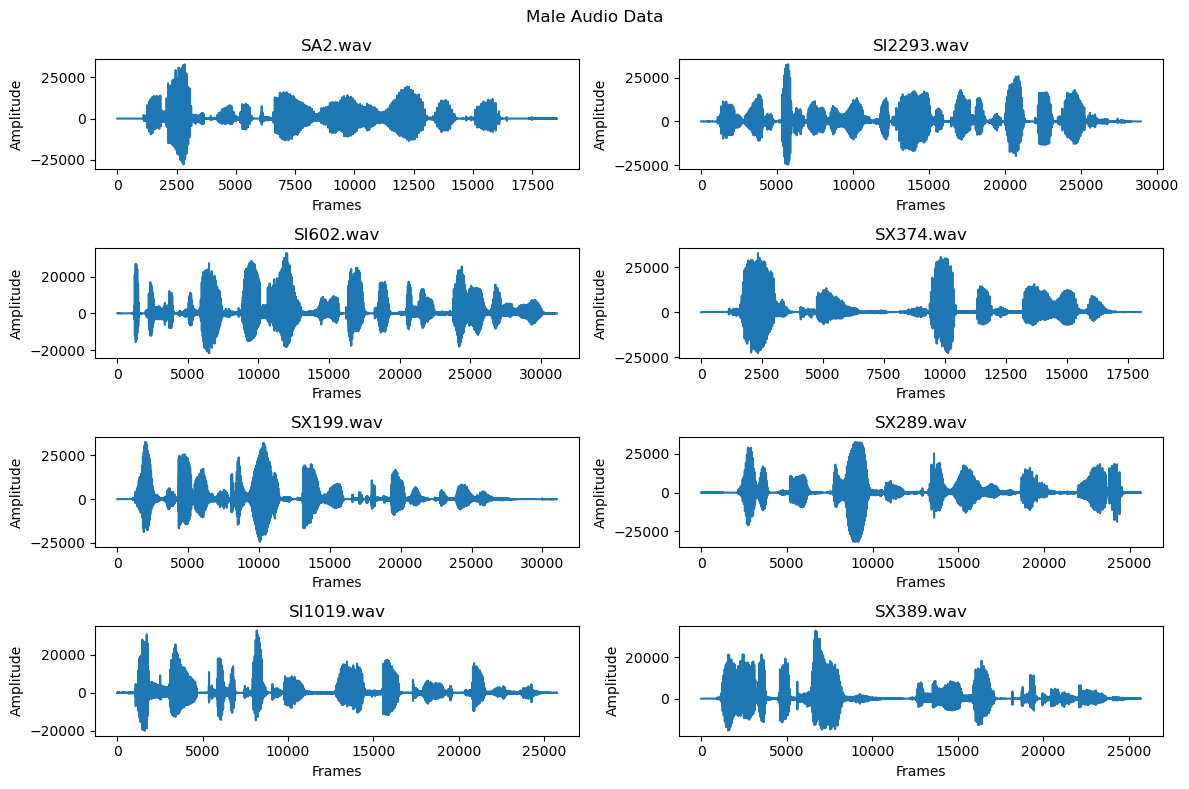

In [56]:
SA1=wav_files_F['F1']['SA1.wav']['frames']
print(SA1)

# Create a figure and subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 8))  # Adjusted the number of subplots to match the number of folders
plt.suptitle("Female Audio Data")

# Iterate over the folders in the wav_files_F dictionary
for i, folder_name in enumerate(wav_files_F):
    # Iterate over the wav files in the folder
    for j, file_name in enumerate(wav_files_F[folder_name]):
        # Get the frames and sample rate
        frames = wav_files_F[folder_name][file_name]['frames']
        sample_rate = wav_files_F[folder_name][file_name]['sample_rate']
        
        # Plot the wav file in the corresponding subplot
        axs[i, j].plot(frames)
        axs[i, j].set_title(file_name)
        axs[i, j].set_xlabel('Frames')
        axs[i, j].set_ylabel('Amplitude')

plt.tight_layout()
# plt.title('Female Audio Data')

fig, axs = plt.subplots(4, 2, figsize=(12, 8))  # Adjusted the number of subplots to match the number of folders
plt.suptitle("Male Audio Data")
# Iterate over the folders in the wav_files_M dictionary
for i, folder_name in enumerate(wav_files_M):
    # Iterate over the wav files in the folder
    for j, file_name in enumerate(wav_files_M[folder_name]):
        # Get the frames and sample rate
        frames = wav_files_M[folder_name][file_name]['frames']
        sample_rate = wav_files_M[folder_name][file_name]['sample_rate']
        
        # Plot the wav file in the corresponding subplot
        axs[i, j].plot(frames)
        axs[i, j].set_title(file_name)
        axs[i, j].set_xlabel('Frames')
        axs[i, j].set_ylabel('Amplitude')

# Adjust the spacing between subplots
plt.tight_layout()


# Show the plot
plt.show()


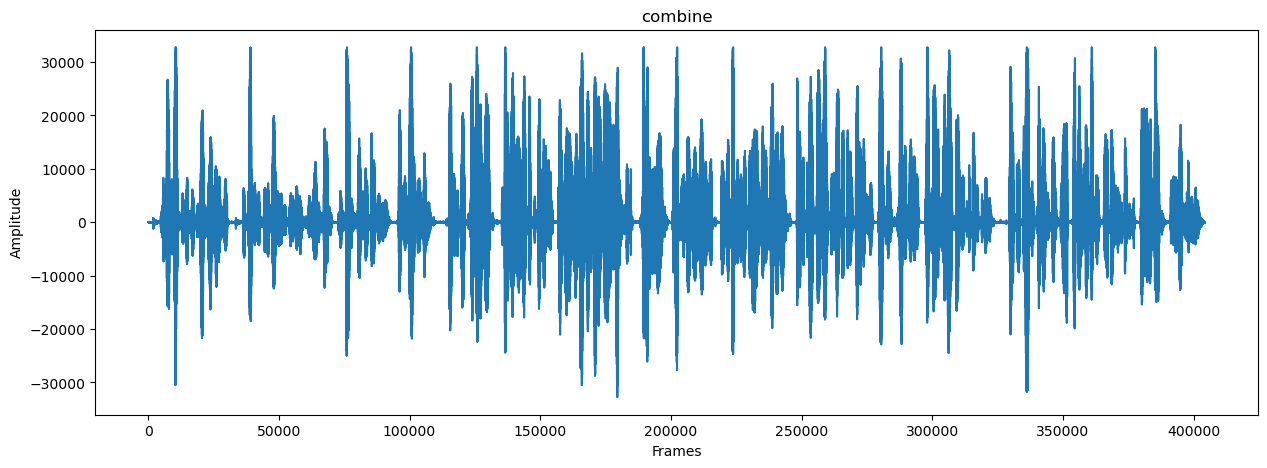

32767
-32767
6468512


In [57]:
#Try use all audio to build the huffman code

# Combine every audio into one audio file
Combined_audio= np.concatenate(audio_data)
plot_wav_file(list(Combined_audio), 'combine')

print(max(Combined_audio))
print(min(Combined_audio))

#calc how many bits to represent the audio
print(len(Combined_audio)*16)

## 3. Normalization

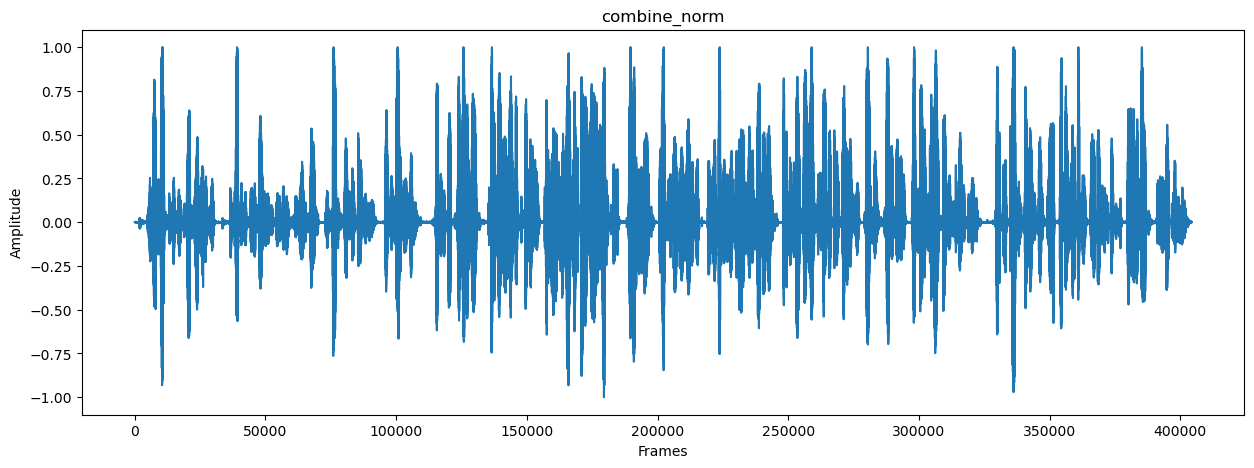

In [58]:

def normalization(Combined_audio):
    """
    Normalize the given audio signal.

    Parameters:
    Combined_audio (ndarray): The input audio signal.

    Returns:
    tuple: A tuple containing the normalized audio signal and the normalization ratio.

    """
    norm_Combined_audio = Combined_audio / np.max(np.abs(Combined_audio))
    ratio = np.max(np.abs(Combined_audio))
    # print("normalized ratio is", ratio)
    return norm_Combined_audio, ratio

norm_Combined_audio, ratio = normalization(Combined_audio)
plot_wav_file(list(norm_Combined_audio), 'combine_norm')


## 4. Quantization

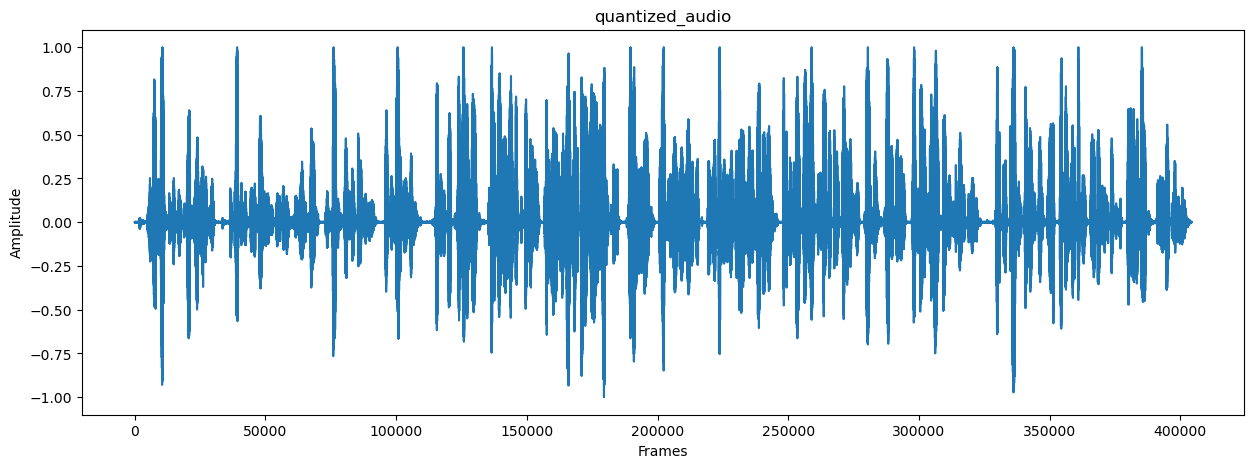

In [59]:

def quantization(audio, N):
    """
    Quantizes the given audio signal using N quantization levels.

    Parameters:
    audio (numpy.ndarray): The input audio signal.
    N (int): The number of quantization levels.

    Returns:
    numpy.ndarray: The quantized audio signal.
    """
    quantization_levels = np.linspace(-1, 1, N)
    quantized_audio = np.zeros(len(audio))
    for i in range(len(audio)):
        index = np.argmin(np.abs(audio[i] * np.ones(len(quantization_levels)) - quantization_levels))
        quantized_audio[i] = quantization_levels[index]
    return quantized_audio, quantization_levels



quantized_audio,quantization_levels = quantization(norm_Combined_audio, 512)
plot_wav_file(list(quantized_audio), 'quantized_audio')




## 5. Huffman coding

In [60]:
def cal_entropy(quantized_audio):
    quantized_audio_char = [str(i) for i in quantized_audio] #convert to string
    counts = Counter(quantized_audio_char)
    prob = [i/len(quantized_audio) for i in counts.values()]

    entropy = -sum([p * math.log2(p) for p in prob])

    

    return entropy
    
def cal_average_code_length(table,quantized_audio):
    quantized_audio_char = [str(i) for i in quantized_audio] #convert to string
    counts = Counter(quantized_audio_char)
    prob = [i/len(quantized_audio) for i in counts.values()]
    unique_chars = list(counts.keys())
    code_length = []
    for i in unique_chars:
        if i in table:
            code_length.append(len(table[i]))

    average_code_length = 0
    for p, l in zip(prob, code_length):
        average_code_length += p * l
    return average_code_length

    
def Huffman_coding(quantized_audio):


    quantized_audio_char = [str(i) for i in quantized_audio] #convert to string
    counts = Counter(quantized_audio_char)

    # create nodes property
    Node = namedtuple('Node', ['count', 'letter', 'left', 'right'])

    # create trees
    nodes = [Node(count, letter, None, None) 
            for (letter, count) in counts.items()]

    heap = nodes.copy() # convert to heap
    heapify(heap)

    while len(heap) > 1:
        left = heappop(heap)
        right = heappop(heap)
        count = left.count + right.count
        node = Node(count, '\0', left, right)
        heappush(heap, node)
    
    tree=heappop(heap)

    table = {}
    make_table(tree, '', table)
    # display(np.transpose(pd.DataFrame(table,index=["CODE"])))

    return quantized_audio_char,tree,table


def is_leaf(node):
    return node.left is None and node.right is None

def make_table(node, path, table):
    if node is None:
        return
    
    if is_leaf(node):
        table[node.letter] = path
        return
    
    make_table(node.left, path+'0', table)
    make_table(node.right, path+'1', table)


def encode(s, table):
    t = []
    for letter in s:
        if letter in table:
            t.append(table[letter])

    
    return ''.join(t)

In [61]:
quantized_audio_char,tree,table = Huffman_coding(quantized_audio)
print(table)
# table size
print(len(table.keys()))

print("The size of the table is", sum(len(table[i]) for i in table.keys()))

code = encode(quantized_audio_char,table)

print("The entropy of the quantized audio is", cal_entropy(quantized_audio))
print("The average code length of the quantized audio is", cal_average_code_length(table,quantized_audio))

{'0.001956947162426559': '00', '0.02544031311154593': '010000', '0.15068493150684925': '010001000', '-0.5538160469667319': '010001001000000', '-0.5616438356164384': '010001001000001', '-0.5851272015655578': '010001001000010', '-0.6086105675146771': '010001001000011', '-0.6203522504892368': '010001001000100', '-0.6320939334637965': '010001001000101', '0.6908023483365948': '010001001000110', '0.7573385518590996': '010001001000111', '-0.4716242661448141': '01000100100100', '-0.4794520547945206': '01000100100101', '-0.5068493150684932': '01000100100110', '-0.5694716242661448': '01000100100111', '0.6164383561643834': '01000100101000', '0.6281800391389432': '01000100101001', '0.6477495107632092': '01000100101010', '0.6516634050880625': '01000100101011', '0.4011741682974559': '010001001011', '-0.31115459882583174': '01000100110', '-0.48727984344422703': '0100010011100', '0.5225048923679059': '0100010011101', '0.3894324853228963': '010001001111', '-0.11154598825831707': '01000101', '-0.0684931

In [62]:
#Decode
def decode(s, tree,norm_ratio=1):
    result = []
    node = tree
    for c in s:
        if c == '0':
            node = node.left
        else:
            node = node.right
            
        if is_leaf(node):
            # print(node.letter)
            result.append(node.letter)
            node = tree

    decode_audio = [float(i)*norm_ratio for i in result]
    # decode_audio = np.array(decode_audio)

            
    return decode_audio


decode_audio = decode(code,tree,ratio) 


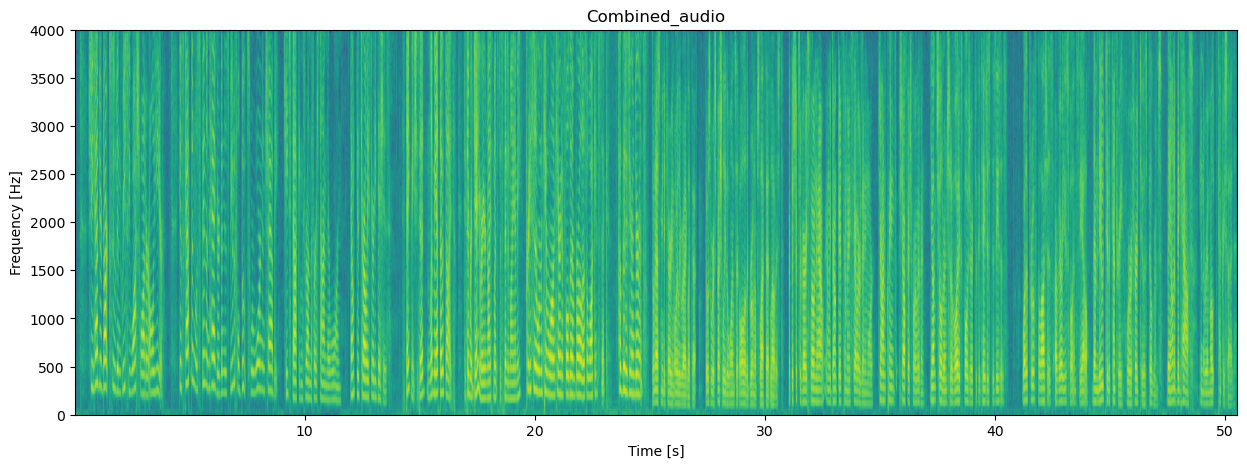

d:\SOFTWARE\Anaconda\Lib\site-packages\matplotlib\axes\_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


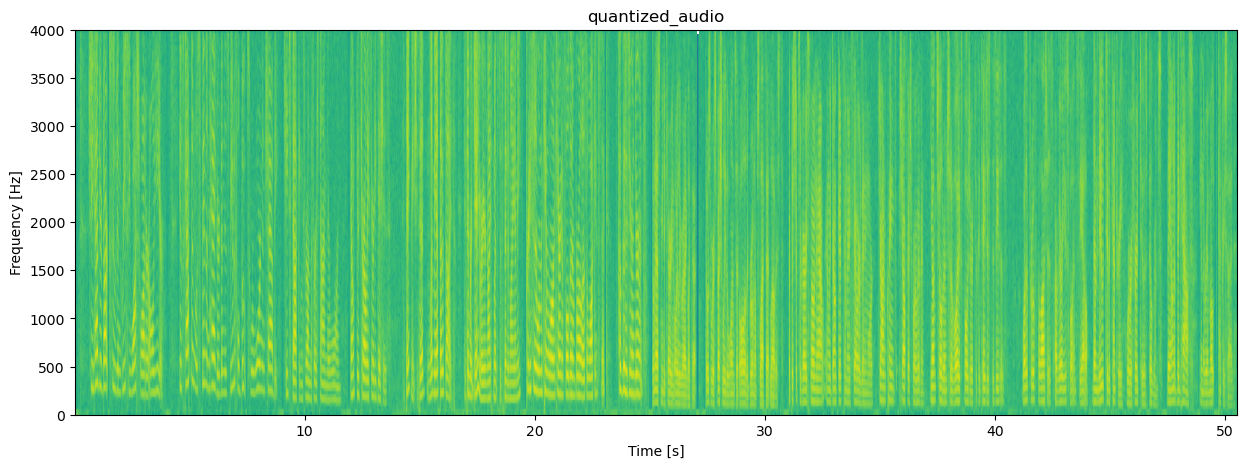

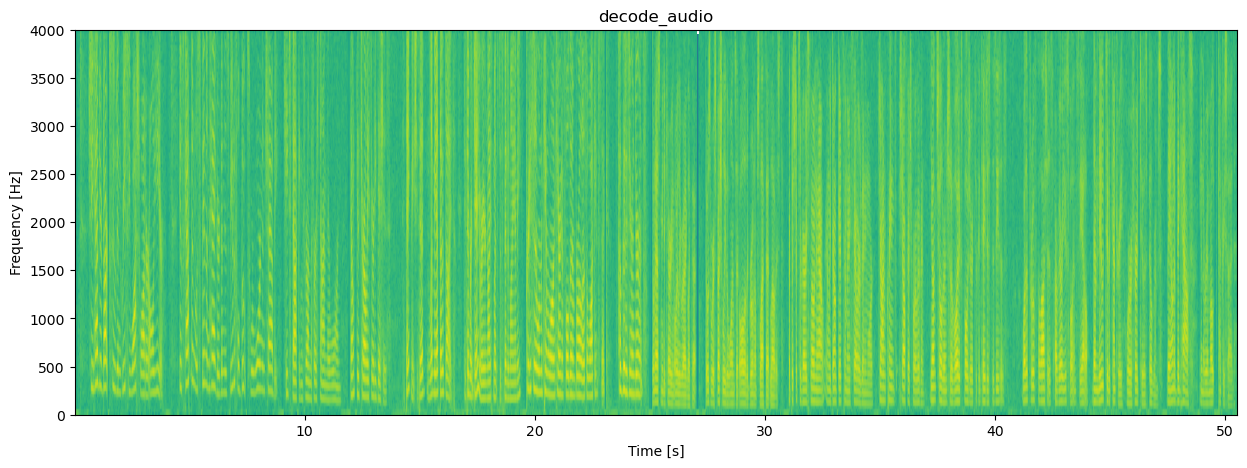

49.3818644408693
41.59631083121923
41.59631083121923


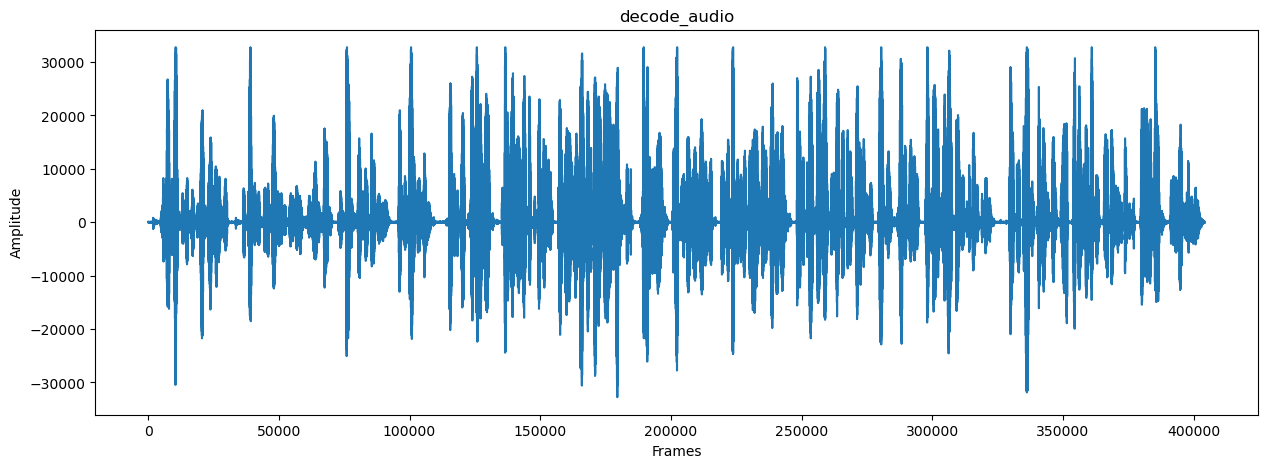

2292510
6468512
0.3544107207345368


In [63]:
#Analysis
# plot of the audio in dB scale spectrogram 
def plot_spectrogram(audio, sample_rate, title):
    # Create the time array
    time = np.arange(0, len(audio)) / sample_rate
    # Plot the spectrogram
    plt.specgram(audio, Fs=sample_rate)
    plt.title(title)
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.show()

plot_spectrogram(Combined_audio, 8000, 'Combined_audio')
plot_spectrogram(quantized_audio, 8000, 'quantized_audio')
plot_spectrogram(decode_audio, 8000, 'decode_audio')

def SNR(NoisyData):
    """
    Calculate the Signal-to-Noise Ratio (SNR) of the given noisy data.

    Parameters:
    NoisyData (array-like): The input noisy data.

    Returns:
    float: The calculated SNR value.
    """
    noise_segment = NoisyData[:1000]
    snr = 10*np.log10(np.var(NoisyData)/np.var((noise_segment)))
    return snr

print(SNR(Combined_audio))
print(SNR(quantized_audio))
print(SNR(decode_audio))

#plot the audio
plot_wav_file(list(decode_audio), 'decode_audio')

#Calculate the compression ratio
print(len(code))
print(len(quantized_audio)*16)
print(len(code)/(len(quantized_audio)*16))

# play the audio
audio = Audio(decode_audio, rate=8000)
audio




In [65]:

# Define quantization levels
N_values = [  128,256,512, 1024, 2048,4096]
M_values = np.arange(1, 16)

# Initialize lists to store the results
original_snr_results = []
decoded_snr_results = []
table_length_results = []
entropy_results = []
average_code_length_results = []
compression_ratio_results = []
encoding_time_results = []
decoding_time_results = []
snr_differece_results = []
code_length_minus_entrqpy_results = []
bit_loss_results = []
bit_loss_rate_results = []


M_list = []
N_list = []

# Perform the circular test
num_tests = 0
for N in N_values:
    for M in M_values:
        original_snr_sum = 0
        decoded_snr_sum = 0
        table_length_sum = 0
        entropy_sum = 0
        average_code_length_sum = 0
        compression_ratio_sum = 0
        encoding_time_sum = 0
        decoding_time_sum = 0
        snr_differece_sum = 0
        code_length_minus_entrqpy_sum=0
        bit_loss_sum=0
        bit_loss_rate_sum=0
        
        for _ in range(10):
            num_tests += 1
            # Perform the test and calculate the results
            print("Test processing: N =", N, "M =", M, "Iteration ", num_tests, " of ",len(M_values)*10*len(N_values))
            random.shuffle(audio_data)

            #Create train data
            train_data=np.concatenate(audio_data[:M])

            #Create test data
            test_data=np.concatenate(audio_data[M:])

            #Create the huffman table for the train data
            norm_train_data, ratio = normalization(train_data)
            quantized_train_data,quantization_levels = quantization(norm_train_data, N)
            quantized_train_audio_char,tree,table = Huffman_coding(quantized_train_data)

            #Encode the train data
            norm_test_data, ratio = normalization(test_data)
            quantized_test_data,quantization_levels = quantization(norm_test_data, N)
            quantized_test_audio_char=[str(i) for i in quantized_test_data] #convert to string
            #Encode the test data
            Time_start = time.time()
            code = encode(quantized_test_audio_char,table)
            #Record the encoding time
            encoding_time = time.time() - Time_start

            #Decode the test data
            Time_start = time.time()
            decode_audio = decode(code,tree,ratio)
            #Record the decoding time
            decoding_time = time.time() - Time_start

            #Calculate the SNR
            original_snr = SNR(test_data)
            decoded_snr = SNR(decode_audio)
            snr_differece = abs(original_snr - decoded_snr)

            bit_loss=abs(len(test_data)-len(decode_audio))
            bit_loss_rate=bit_loss/len(test_data)

            #Calculate the entropy
            entropy = cal_entropy(quantized_test_data)

            #Calculate the average code length
            average_code_length = cal_average_code_length(table,quantized_test_data)

            #Calculate the compression ratio
            compression_ratio = len(code)/(len(quantized_test_data)*16)

            # Accumulate the results
            original_snr_sum += original_snr
            decoded_snr_sum += decoded_snr
            table_length_sum += sum(len(table[i]) for i in table.keys())
            entropy_sum += entropy
            average_code_length_sum += average_code_length
            compression_ratio_sum += compression_ratio
            encoding_time_sum += encoding_time
            decoding_time_sum += decoding_time
            snr_differece_sum += snr_differece
            bit_loss_sum+=bit_loss
            bit_loss_rate_sum+=bit_loss_rate
        
        # Calculate the average results
        original_snr_avg = original_snr_sum / 10
        decoded_snr_avg = decoded_snr_sum / 10
        table_length_avg = table_length_sum / 10
        entropy_avg = entropy_sum / 10
        average_code_length_avg = average_code_length_sum / 10
        compression_ratio_avg = compression_ratio_sum / 10
        encoding_time_avg = encoding_time_sum / 10
        decoding_time_avg = decoding_time_sum / 10
        snr_differece_avg = snr_differece_sum / 10
        code_length_minus_entrqpy_avg=average_code_length_avg-entropy_avg
        bit_loss_avg=bit_loss_sum/10
        bit_loss_rate_avg=bit_loss_rate_sum/10
        
        # Record the results
        original_snr_results.append(original_snr_avg)
        decoded_snr_results.append(decoded_snr_avg)
        table_length_results.append(table_length_avg)
        entropy_results.append(entropy_avg)
        average_code_length_results.append(average_code_length_avg)
        compression_ratio_results.append(compression_ratio_avg)
        encoding_time_results.append(encoding_time_avg)
        decoding_time_results.append(decoding_time_avg)
        snr_differece_results.append(snr_differece_avg)
        code_length_minus_entrqpy_results.append(code_length_minus_entrqpy_avg)
        bit_loss_results.append(bit_loss_avg)
        bit_loss_rate_results.append(bit_loss_rate_avg)

        M_list.append(M)
        N_list.append(N)

# Print the recorded results
print("Original SNR:", original_snr_results)
print("Decoded SNR:", decoded_snr_results)
print("Table Length:", table_length_results)
print("Entropy:", entropy_results)
print("Average Code Length:", average_code_length_results)
print("Compression Ratio:", compression_ratio_results)
print("Encoding Time:", encoding_time_results)
print("Decoding Time:", decoding_time_results)
print("SNR Difference:", snr_differece_results)
print("Code Length Minus Entropy:", code_length_minus_entrqpy_results)




Test processing: N = 128 M = 1 Iteration  1  of  900
Test processing: N = 128 M = 1 Iteration  2  of  900
Test processing: N = 128 M = 1 Iteration  3  of  900
Test processing: N = 128 M = 1 Iteration  4  of  900
Test processing: N = 128 M = 1 Iteration  5  of  900
Test processing: N = 128 M = 1 Iteration  6  of  900
Test processing: N = 128 M = 1 Iteration  7  of  900
Test processing: N = 128 M = 1 Iteration  8  of  900
Test processing: N = 128 M = 1 Iteration  9  of  900
Test processing: N = 128 M = 1 Iteration  10  of  900
Test processing: N = 128 M = 2 Iteration  11  of  900
Test processing: N = 128 M = 2 Iteration  12  of  900
Test processing: N = 128 M = 2 Iteration  13  of  900
Test processing: N = 128 M = 2 Iteration  14  of  900
Test processing: N = 128 M = 2 Iteration  15  of  900
Test processing: N = 128 M = 2 Iteration  16  of  900
Test processing: N = 128 M = 2 Iteration  17  of  900
Test processing: N = 128 M = 2 Iteration  18  of  900
Test processing: N = 128 M = 2 Iterat

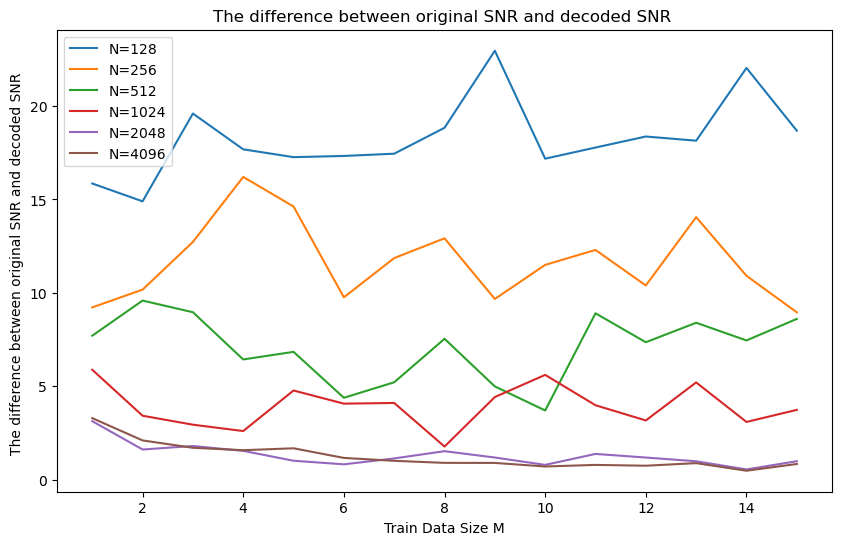

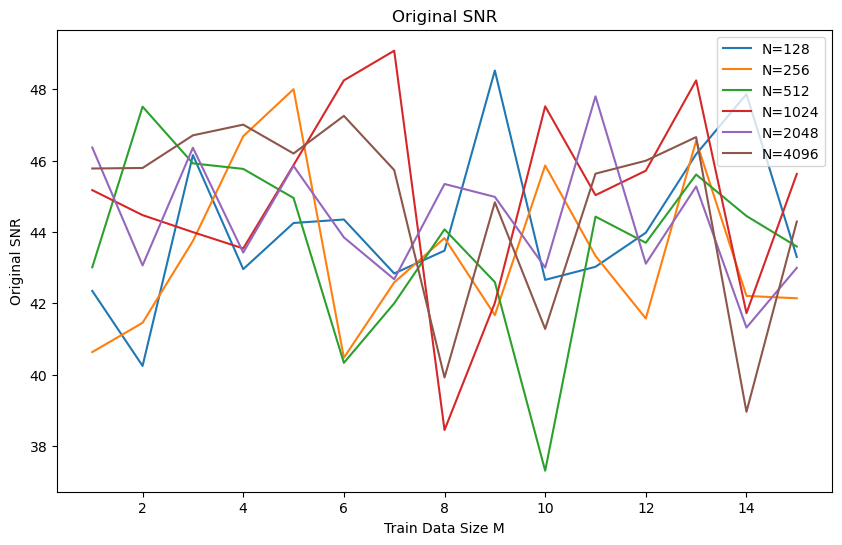

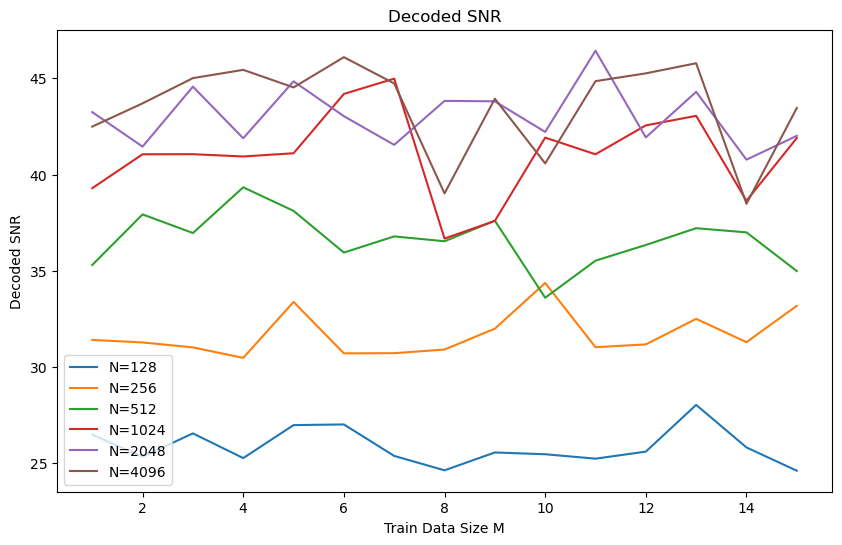

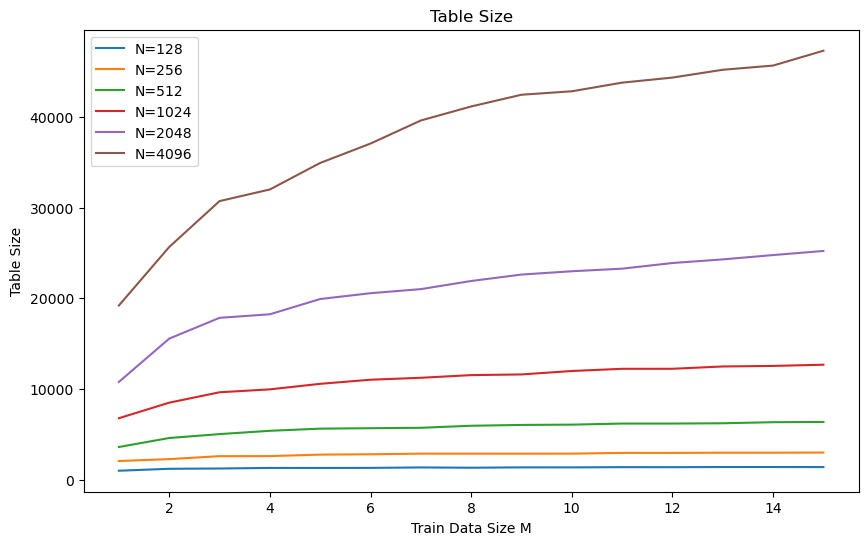

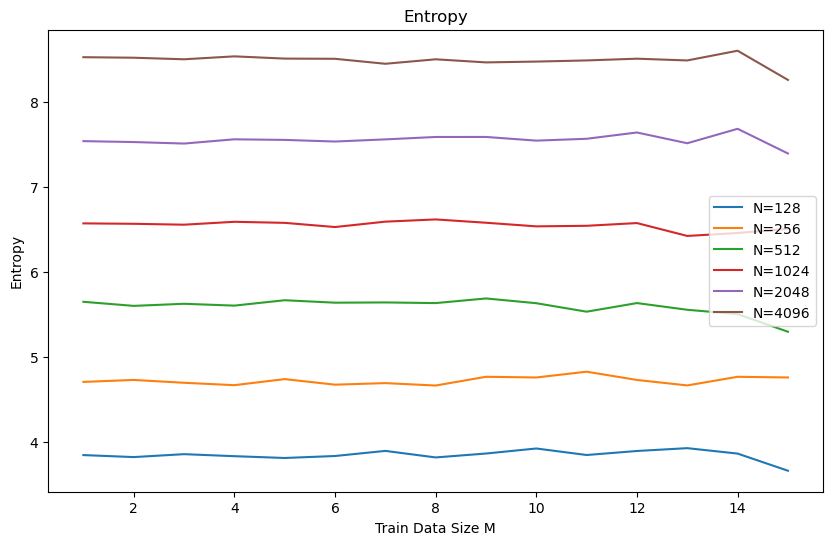

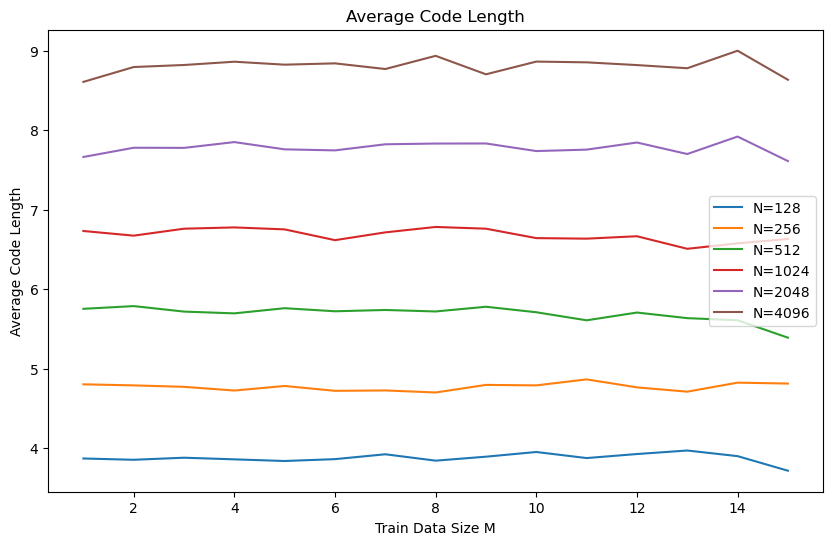

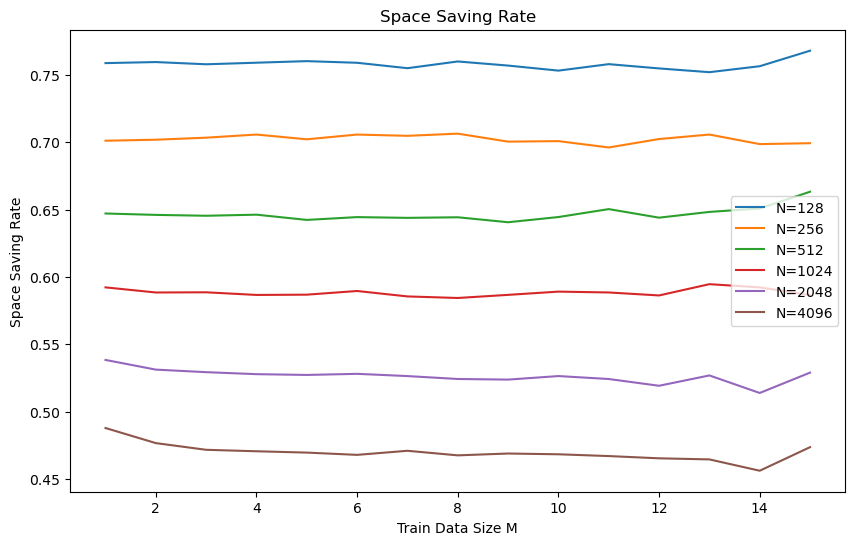

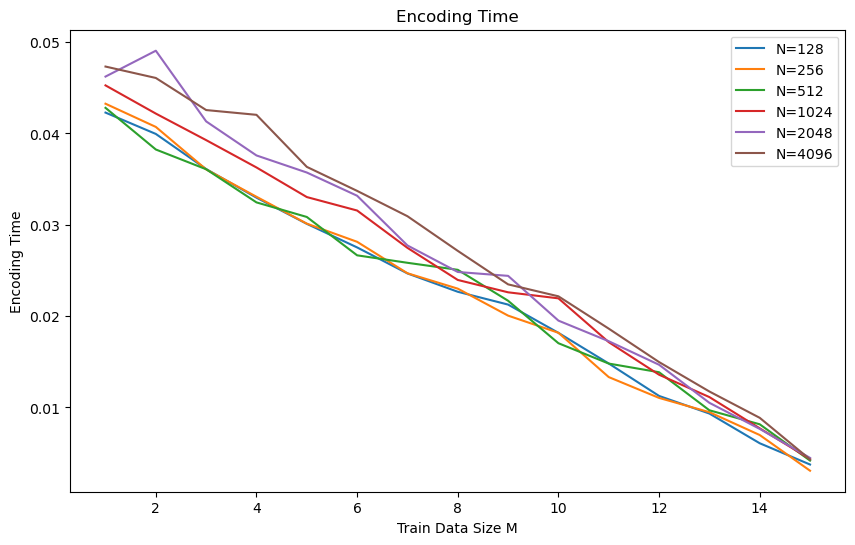

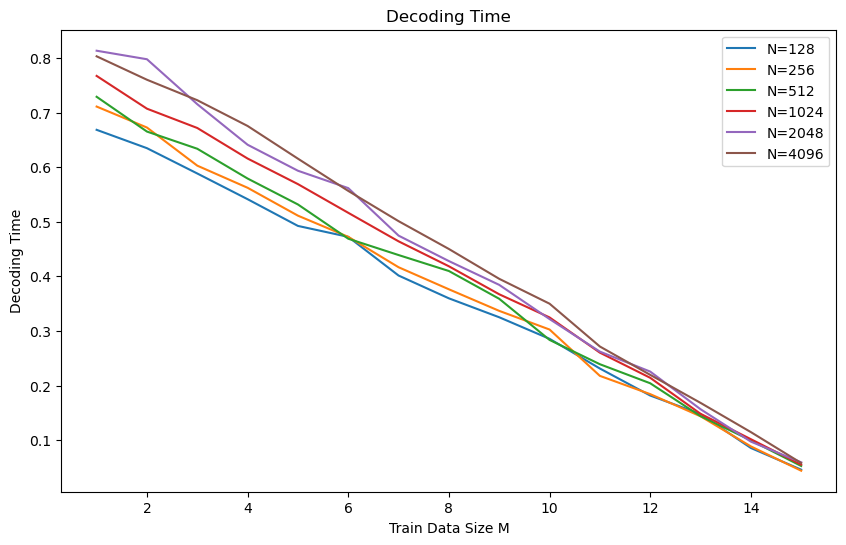

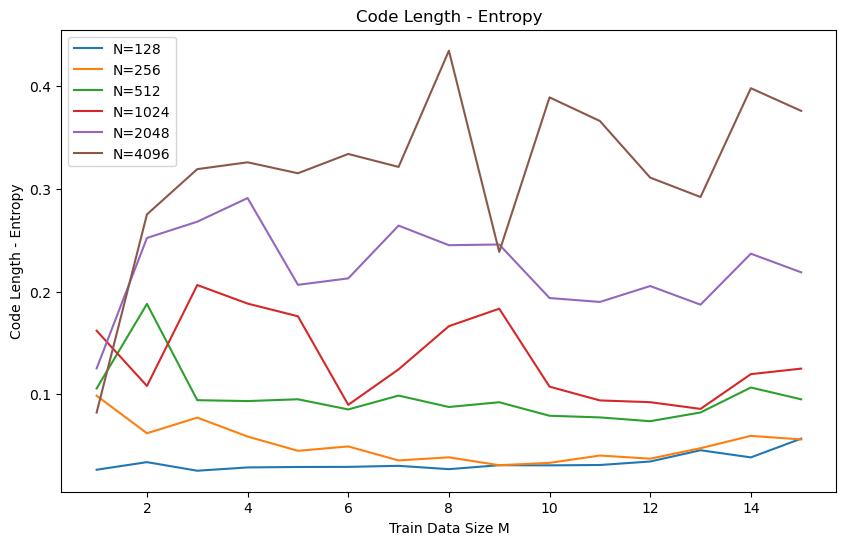

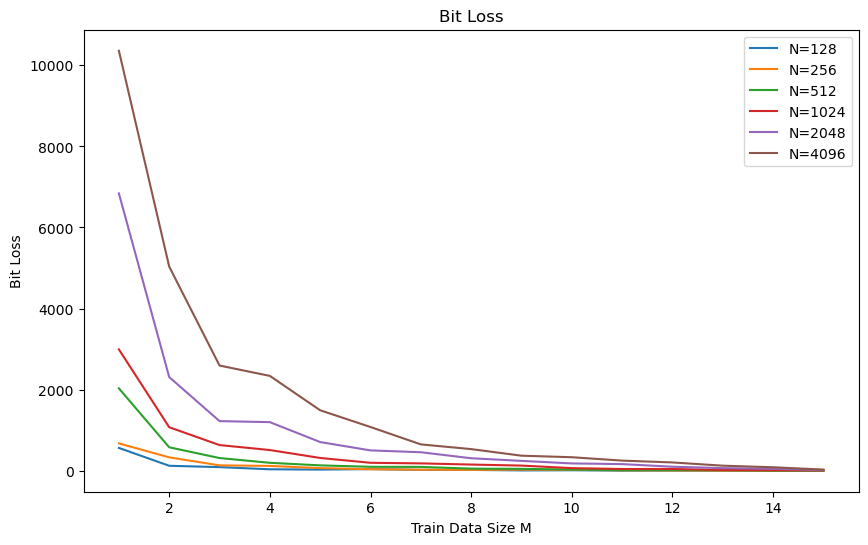

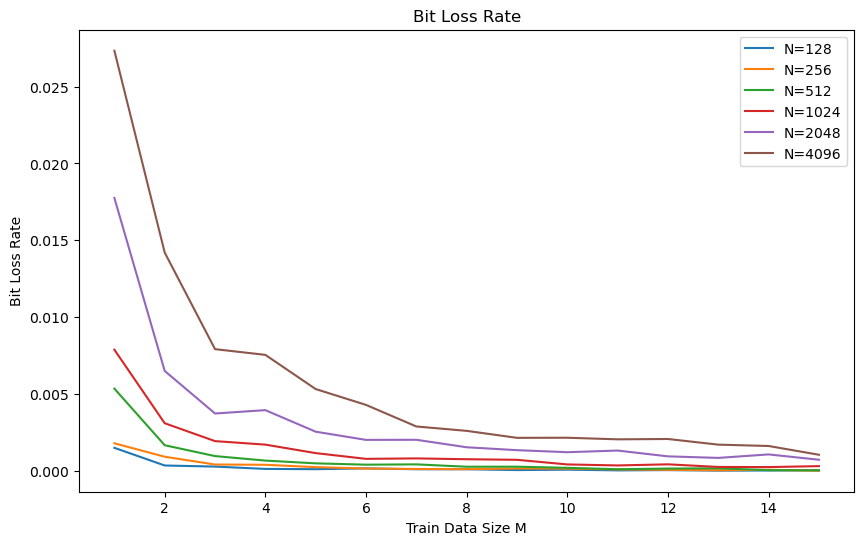

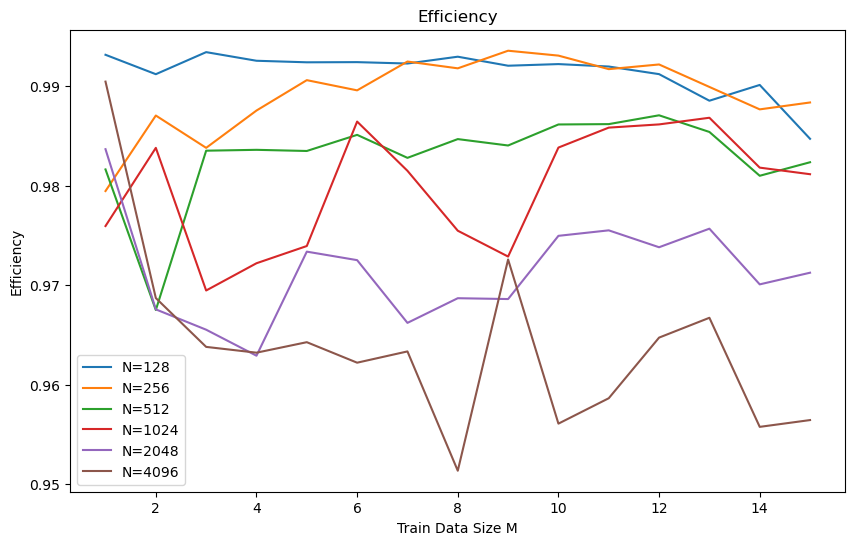

In [74]:
compression_ratio_results=np.ones(len(compression_ratio_results))-compression_ratio_results

#efficiency
efficiency=[entropy_results[i]/average_code_length_results[i] for i in range(len(entropy_results))]

# Create a list of results
results = [snr_differece_results,original_snr_results, decoded_snr_results, table_length_results, entropy_results, average_code_length_results, compression_ratio_results, encoding_time_results, decoding_time_results,code_length_minus_entrqpy_results,bit_loss_results,bit_loss_rate_results,efficiency]

# Create a list of result names
result_names = ["The difference between original SNR and decoded SNR ","Original SNR", "Decoded SNR", "Table Size", "Entropy", "Average Code Length", "Space Saving Rate", "Encoding Time", "Decoding Time","Code Length - Entropy","Bit Loss","Bit Loss Rate","Efficiency"]

# For each result
for i in range(len(results)):
    plt.figure(figsize=(10, 6))
    for N in N_values:
        # Filter the results for the current N value
        filtered_results = [results[i][j] for j in range(len(results[i])) if N_list[j] == N]
        # Plot the results
        plt.plot(M_values, filtered_results, label=f"N={N}")
    # Set the title, labels, and legend
    plt.title(result_names[i])
    plt.xlabel("Train Data Size M")
    plt.ylabel(result_names[i])
    plt.legend()
    #save the figure
    plt.savefig(result_names[i]+".png")
    
    # Show the plot
    plt.show()
